## BUSINESS PROBLEM 
British Airways (BA) operates in a highly competitive airline industry where customer experience is a key differentiator. With thousands of flights arriving and departing daily, BA interacts with millions of customers across various touchpoints, from booking and check-in to in-flight services and post-flight feedback. However, ensuring consistently high customer satisfaction is challenging due to various factors, including operational inefficiencies, service disruptions, and evolving customer expectations.

Customer feedback, available on third-party review platforms, provides valuable insights into these experiences, but BA currently lacks an automated, data-driven approach to systematically analyze and leverage this information. Without structured analysis, BA risks overlooking critical trends, missing opportunities to enhance customer service, and failing to address recurring issues that negatively impact brand reputation and customer loyalty.

## TASK OVERVIEW
The objective of this task is to develop a data-driven framework for collecting, analyzing, and deriving insights from customer reviews to enhance BA’s service quality and operational efficiency.
Understand Customer Sentiment – Identify common themes in customer feedback, including positive experiences and recurring pain points, to gain a deeper understanding of customer satisfaction levels.

 1.Uncover Service Improvement Areas – Pinpoint key operational and service-related issues that negatively impact customer experience, such as delays, baggage handling, or in-flight services.

 2.Drive Data-Informed Decision-Making – Provide actionable insights that help BA’s leadership and operations teams make informed business decisions to enhance service delivery and customer engagement.

 3.Boost Competitive Advantage – Use customer insights to refine BA’s customer experience strategy, strengthen brand loyalty, and maintain a competitive edge in the airline industry.

By achieving these objectives, BA can proactively address customer concerns, improve service offerings, and enhance its reputation as a leading global airline, ultimately driving increased customer retention and revenue growth.

## Task 1.Data collection via web scraping.
To gather customer feedback data for analysis, we will identify third-party platforms that host British Airways (BA) reviews, eg. Trustpilot, Skytrax, TripAdvisor, Google Reviews, Reddit, and Consumer Affairs. These platforms provide valuable insights into passenger experiences, service quality, and common concerns. Using web scraping techniques, we will collect structured data while ensuring compliance with ethical and legal guidelines. This dataset will serve as the foundation for our analysis, helping us uncover key trends, customer sentiments, and areas for service improvement within BA.

#### Import and install necessary libraries

In [45]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import csv

import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import string 

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berylsaoke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Base URL and pagination settings
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

# List to store review data
reviews = []

# Loop through the pages and fetch reviews
for i in range(1, pages + 1):
    print(f"Scraping page {i}...")
    # Construct the URL for the page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)

    # check if the request was successful status code is 200=okay 
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Loop through each review block by finding all sections on the page that contains reviews 
        review_blocks = soup.find_all("div", {"class": "review-stats"})
        for block in review_blocks:
            review_data = {}

            # Extract review table details
            table = block.find("table", {"class": "review-ratings"})
            if table:
                rows = table.find_all("tr")
                for row in rows:
                    header = row.find("td", {"class": "review-rating-header"}).get_text(strip=True)
                    value = None

                    # Handle star ratings and text-based values
                    if row.find("td", {"class": "review-value"}):
                        value = row.find("td", {"class": "review-value"}).get_text(strip=True)
                    elif row.find("td", {"class": "review-rating-stars"}):
                        stars = row.find("td", {"class": "review-rating-stars"}).find_all("span", {"class": "star fill"})
                        value = len(stars)  # Count filled stars

                    review_data[header] = value

            # Extract the text content of the review
            text_content = block.find_next("div", {"class": "text_content"})
            review_data["Review Text"] = text_content.get_text(strip=True) if text_content else None

            # Append the data to the reviews list
            reviews.append(review_data)
    else:
        print(f"Failed to retrieve page {i}. Status code: {response.status_code}")

    print(f"   ---> {len(reviews)} total reviews so far")

# Convert the reviews into a DataFrame
df = pd.DataFrame(reviews)
df.to_csv("BA_reviews.csv")



Scraping page 1...
   ---> 100 total reviews so far
Scraping page 2...
   ---> 200 total reviews so far
Scraping page 3...
   ---> 300 total reviews so far
Scraping page 4...
   ---> 400 total reviews so far
Scraping page 5...
   ---> 500 total reviews so far
Scraping page 6...
   ---> 600 total reviews so far
Scraping page 7...
   ---> 700 total reviews so far
Scraping page 8...
   ---> 800 total reviews so far
Scraping page 9...
   ---> 900 total reviews so far
Scraping page 10...
   ---> 1000 total reviews so far


## Task 2 Inspect Data

We first begin by inspecting the data to be able to proceed with data cleaning 

In [47]:
df.head()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended,Review Text,Aircraft,Wifi & Connectivity
0,Couple Leisure,Economy Class,Zürich to London,December 2024,2.0,2.0,1.0,1.0,1.0,1,no,✅Trip Verified| London Heathrow to Male In n...,NaN,NaN
1,Couple Leisure,Business Class,London to Male,January 2025,5.0,5.0,4.0,5.0,5.0,4,yes,Not Verified| Very good flight following an e...,Boeing 777,NaN
2,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,3.0,4.0,4.0,NaN,4.0,4,yes,Not Verified| An hour's delay due to late arr...,A320,NaN
3,Family Leisure,Economy Class,London to Lisbon,January 2025,3.0,4.0,2.0,NaN,4.0,4,yes,✅Trip Verified| I booked through BA because ...,A319,NaN
4,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,NaN,NaN,NaN,NaN,1.0,1,no,✅Trip Verified| British airways lost bags in...,NaN,NaN


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type Of Traveller       998 non-null    object 
 1   Seat Type               1000 non-null   object 
 2   Route                   996 non-null    object 
 3   Date Flown              1000 non-null   object 
 4   Seat Comfort            912 non-null    float64
 5   Cabin Staff Service     902 non-null    float64
 6   Food & Beverages        779 non-null    float64
 7   Inflight Entertainment  520 non-null    float64
 8   Ground Service          943 non-null    float64
 9   Value For Money         1000 non-null   int64  
 10  Recommended             1000 non-null   object 
 11  Review Text             990 non-null    object 
 12  Aircraft                525 non-null    object 
 13  Wifi & Connectivity     324 non-null    float64
dtypes: float64(6), int64(1), object(7)
memory

In [49]:
df.describe()

,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity
count,912.000000,902.000000,779.000000,520.000000,943.000000,1000.000000,324.000000
mean,2.712719,3.118625,2.625160,2.746154,2.488865,2.313000,2.203704
std,1.387862,1.523150,1.470597,1.446870,1.535024,1.458478,1.481104
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000
75%,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [50]:
df.isnull().sum()

Type Of Traveller           2
Seat Type                   0
Route                       4
Date Flown                  0
Seat Comfort               88
Cabin Staff Service        98
Food & Beverages          221
Inflight Entertainment    480
Ground Service             57
Value For Money             0
Recommended                 0
Review Text                10
Aircraft                  475
Wifi & Connectivity       676
dtype: int64

In [51]:
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 0


## Task 2 Data Cleaning
 Key Observations

Missing Data:

Several columns, such as "Aircraft" (475 missing), "Inflight Entertainment" (480 missing), and "Wifi & Connectivity" (676 missing), have significant missing values.
The "Review Text" is mostly complete (only 10 missing), making it useful for sentiment analysis.
 Columns of Interest:

Type of Traveller": Solo, Family, Business.

Seat Type": Economy, Premium Economy, Business Class.

Route": Flight routes taken by customers.

 Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service": Rated from 1 to 5.
 
Value for Money": Numeric value scored between  1 being the lowest score to 5as the highest score.

 Recommended": Yes/No indicating whether the traveler would recommend BA.

 Review Text": Detailed text reviews.

Will begin my data cleaning by dropping columns i render not useful for this analysis

In [52]:
columns_to_keep = ["Type Of Traveller", "Seat Type", "Route", "Date Flown", "Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service", "Value For Money", "Recommended", "Review Text"]
df2 = df[columns_to_keep]
df2.head()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Review Text
0,Couple Leisure,Economy Class,Zürich to London,December 2024,2.0,2.0,1.0,1.0,1,no,✅Trip Verified| London Heathrow to Male In n...
1,Couple Leisure,Business Class,London to Male,January 2025,5.0,5.0,4.0,5.0,4,yes,Not Verified| Very good flight following an e...
2,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,3.0,4.0,4.0,4.0,4,yes,Not Verified| An hour's delay due to late arr...
3,Family Leisure,Economy Class,London to Lisbon,January 2025,3.0,4.0,2.0,4.0,4,yes,✅Trip Verified| I booked through BA because ...
4,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,NaN,NaN,NaN,1.0,1,no,✅Trip Verified| British airways lost bags in...


after creating my new dataframe with the columns or interest, for me to begin my data cleaning i first Check for missing values. 

In [53]:
df2.isnull().sum()

Type Of Traveller        2
Seat Type                0
Route                    4
Date Flown               0
Seat Comfort            88
Cabin Staff Service     98
Food & Beverages       221
Ground Service          57
Value For Money          0
Recommended              0
Review Text             10
dtype: int64

the columns Type Of Traveller', 'Route', 'Review Text' have the following missing values 2, 4, 10 respectively. We go ahead and drop these rows from these columns.

For columns like Seat Comfort, Cabin Staff Service, Food & Beverages, and Ground Service, the following imputation strategies can be implemented:

Mode (Most Frequent Value) – Best if ratings cluster around a specific value (e.g., "4" is the most common).
Median – A safer choice that prevents outliers from skewing the data.
Mean – Suitable if ratings are normally distributed without extreme values.

In [54]:
df2.dropna(subset=['Type Of Traveller', 'Route', 'Review Text'], inplace=True)

numerical_cols = ["Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service"]
df2[numerical_cols] = df2[numerical_cols].apply(lambda x: x.fillna(x.median()))


Its important to check for duplicates as this can alter or scew your ananlysis

In [55]:
df2['Date Flown'] = pd.to_datetime(df2['Date Flown'], errors='coerce')
df2['Year'] = df2['Date Flown'].dt.year
df2['Month'] = df2['Date Flown'].dt.month
df2['Season'] = df2['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')



In [56]:


def clean_text(text):
    text = str(text).lower()  
    text = re.sub(r'\✅|✔|✈️|🌍', '', text)  
    text = re.sub(r'\|', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df2['Cleaned Review'] = df2['Review Text'].apply(clean_text)


In [57]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

df2['Cleaned Review'] = df2['Cleaned Review'].apply(lemmatize_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/berylsaoke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/berylsaoke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
df2['Review Length'] = df2['Cleaned Review'].apply(lambda x: len(x.split()))


In [59]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df2['Sentiment Score'] = df2['Cleaned Review'].apply(get_sentiment)

# Categorize sentiment
df2['Sentiment Label'] = df2['Sentiment Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


In [60]:
print(df2.dtypes)
print(df2['Sentiment Score'].head())  # Preview data


Type Of Traveller              object
Seat Type                      object
Route                          object
Date Flown             datetime64[ns]
Seat Comfort                  float64
Cabin Staff Service           float64
Food & Beverages              float64
Ground Service                float64
Value For Money                 int64
Recommended                    object
Review Text                    object
Year                            int64
Month                           int64
Season                         object
Cleaned Review                 object
Review Length                   int64
Sentiment Score               float64
Sentiment Label                object
dtype: object
0    0.281960
1    0.344286
2    0.122222
3    0.035417
4   -0.066667
Name: Sentiment Score, dtype: float64


In [61]:
df2 = df2.drop(columns=['Type Of Traveller', 'Route', 'Date Flown', 'Review Text', 'Review Length'])



In [62]:
categorical_cols = df2.select_dtypes(include=['object']).columns

df2[categorical_cols] = df2[categorical_cols].apply(lambda x: x.str.lower())
df2.to_csv("Cleaned_data.csv", index=False)

df2.head()

,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Year,Month,Season,Cleaned Review,Sentiment Score,Sentiment Label
0,economy class,2.0,2.0,1.0,1.0,1,no,2024,12,winter,trip verified london heathrow to male in new b...,0.281960,positive
1,business class,5.0,5.0,4.0,5.0,4,yes,2025,1,winter,not verified very good flight following an equ...,0.344286,positive
2,business class,3.0,4.0,4.0,4.0,4,yes,2025,1,winter,not verified an hour delay due to late arrival...,0.122222,positive
3,economy class,3.0,4.0,2.0,4.0,4,yes,2025,1,winter,trip verified i booked through ba because loga...,0.035417,positive
4,economy class,3.0,3.0,3.0,1.0,1,no,2024,11,fall,trip verified british airway lost bag in lhr t...,-0.066667,negative


In [63]:
df2["Verified"] = df2["Cleaned Review"].str.extract(r'(trip verified|not verified)')


df2["Cleaned Review"] = df2["Cleaned Review"].str.replace(r'(trip verified|not verified)', '', regex=True).str.strip()

# Display first few rows to confirm changes
df2.head()


,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Year,Month,Season,Cleaned Review,Sentiment Score,Sentiment Label,Verified
0,economy class,2.0,2.0,1.0,1.0,1,no,2024,12,winter,london heathrow to male in new business class ...,0.281960,positive,trip verified
1,business class,5.0,5.0,4.0,5.0,4,yes,2025,1,winter,very good flight following an equally good fli...,0.344286,positive,not verified
2,business class,3.0,4.0,4.0,4.0,4,yes,2025,1,winter,an hour delay due to late arrival of the incom...,0.122222,positive,not verified
3,economy class,3.0,4.0,2.0,4.0,4,yes,2025,1,winter,i booked through ba because loganair dont have...,0.035417,positive,trip verified
4,economy class,3.0,3.0,3.0,1.0,1,no,2024,11,fall,british airway lost bag in lhr then found them...,-0.066667,negative,trip verified


In [64]:

df2["Recommended"] = df2["Recommended"].map({"yes": 1, "no": 0})

## Task 3 Sentiment Analysis

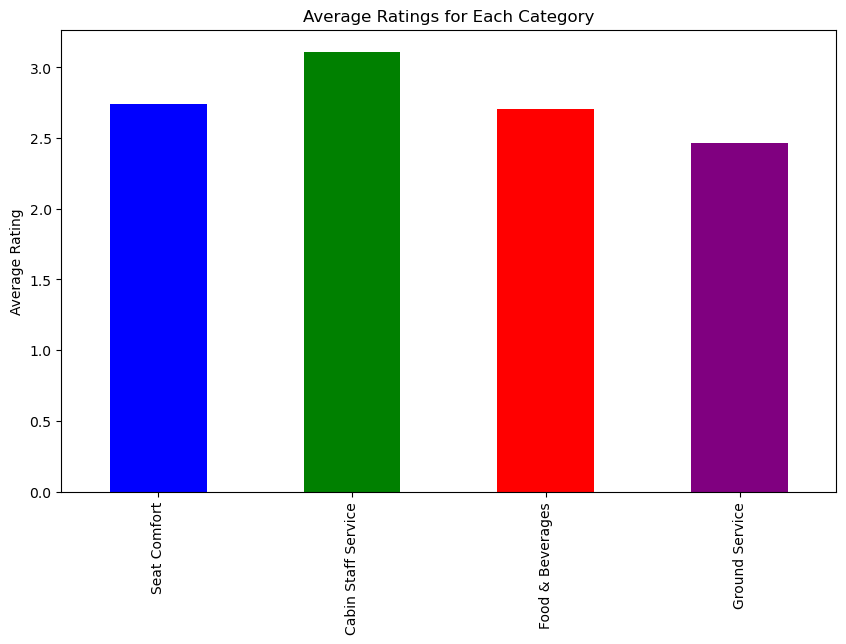

In [74]:
plt.figure(figsize=(10, 6))
ratings = ["Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service"]
df2[ratings].mean().plot(kind="bar", color=["blue", "green", "red", "purple"])
plt.title("Average Ratings for Each Category")
plt.ylabel("Average Rating")
plt.savefig('Average_Rating')
plt.show()

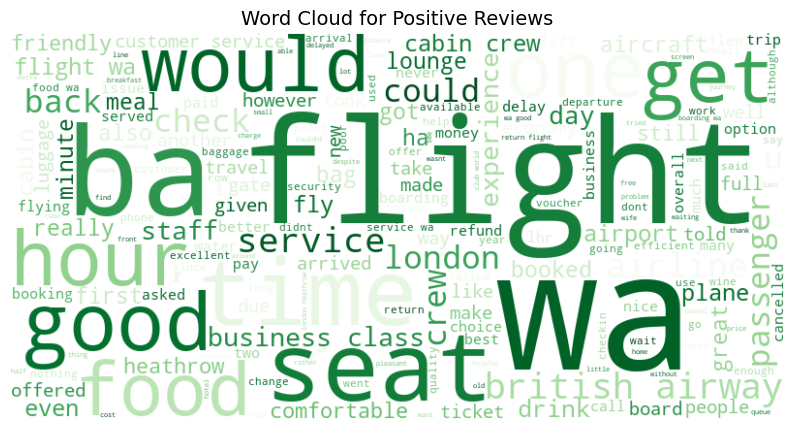

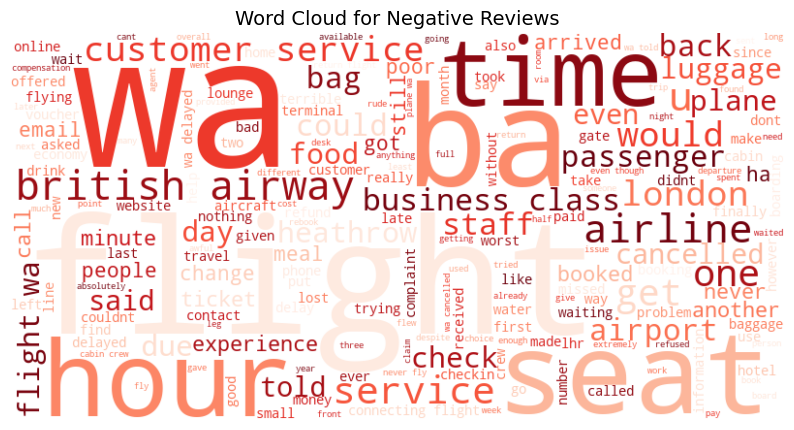

In [66]:
# Define stop words (common words to exclude)
stop_words = set(stopwords.words("english"))

def generate_wordcloud(sentiment, color_map):
    """Generates a word cloud for a given sentiment."""
    text = " ".join(df2[df2["Sentiment Label"] == sentiment]["Cleaned Review"])
    
    wordcloud = WordCloud(
        width=800, height=400, 
        stopwords=stop_words, 
        background_color="white", 
        colormap=color_map
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Reviews", fontsize=14)
    plt.savefig('Review_analysis')
    plt.show()

# Generate word clouds for positive and negative reviews
generate_wordcloud("positive", "Greens")  # Green for positive sentiment
generate_wordcloud("negative", "Reds")    # Red for negative sentiment


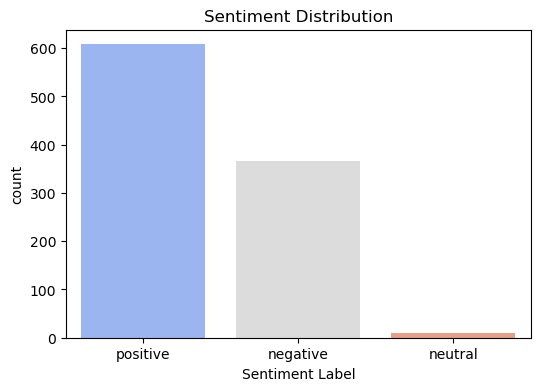

In [67]:
 
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment Label', data=df2, palette='coolwarm')
plt.title("Sentiment Distribution")
plt.savefig('Sentiment_analysis')
plt.show()

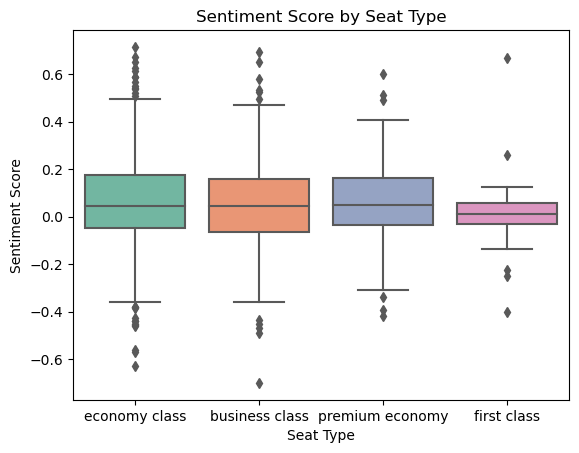

In [68]:
sns.boxplot(x='Seat Type', y='Sentiment Score', data=df2, palette='Set2')
plt.title("Sentiment Score by Seat Type")
plt.savefig("Sentiment_Score_by_Seat_Type")
plt.show()

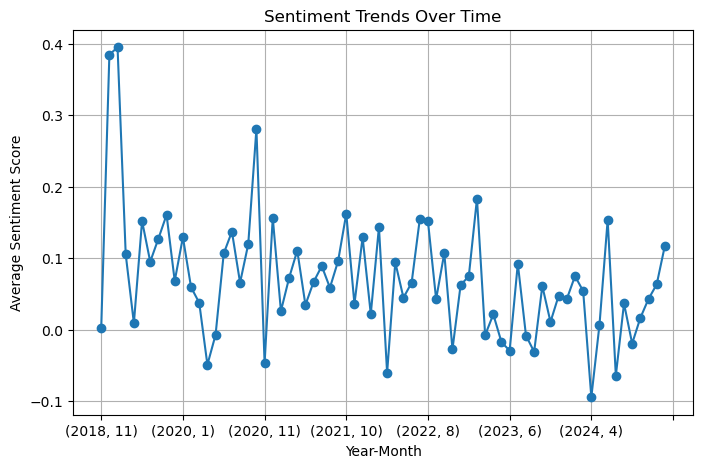

In [69]:
df2.groupby(['Year', 'Month'])['Sentiment Score'].mean().plot(kind='line', marker='o', figsize=(8, 5))
plt.title("Sentiment Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average Sentiment Score")
plt.grid()
plt.savefig("Average_Sentiment_Score")
plt.show()

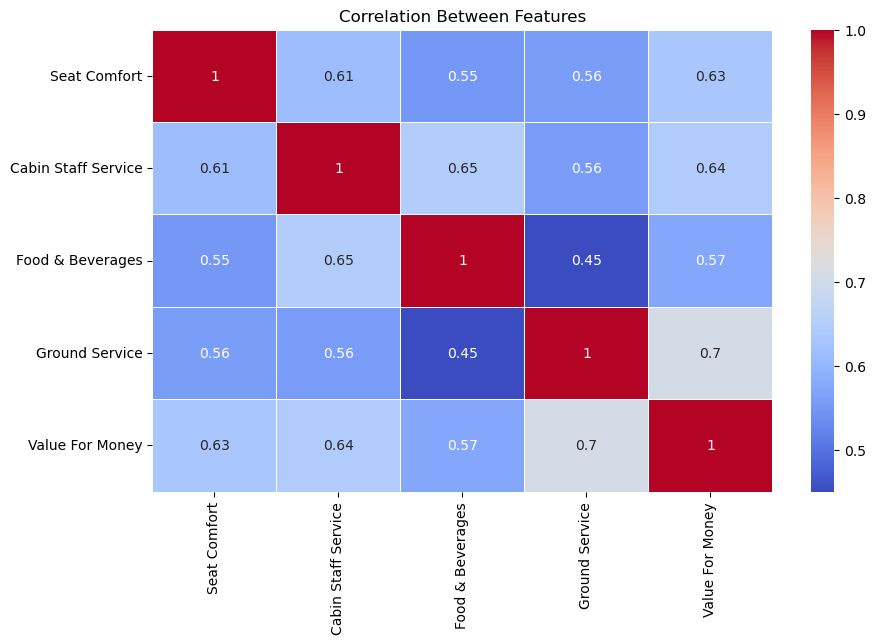

In [70]:
feature_cols = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']
plt.figure(figsize=(10, 6))
sns.heatmap(df2[feature_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Features")
plt.savefig("Correlation_Between_Features")
plt.show()

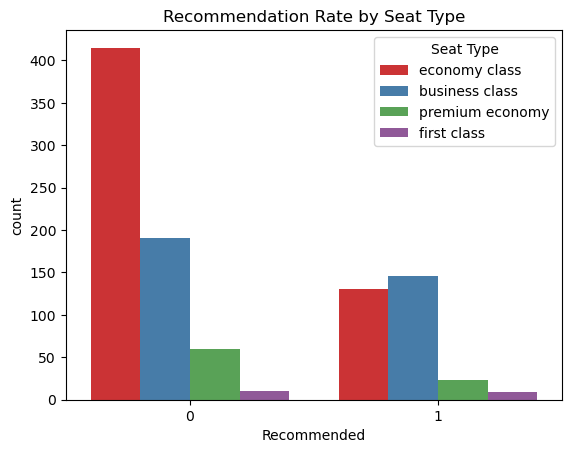

In [71]:
sns.countplot(x='Recommended', hue='Seat Type', data=df2, palette='Set1')
plt.title("Recommendation Rate by Seat Type")
plt.savefig("Recommendation_Rate_by_Seat_Type")
plt.show()

In [72]:
value_for_money_count = df2[df2['Value For Money'] >= 3]['Value For Money'].count()
print(f"Number of people who believe they are getting value for money: {value_for_money_count}")

Number of people who believe they are getting value for money: 395


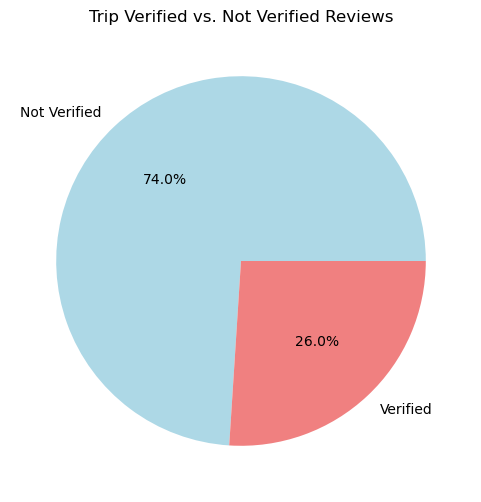

In [73]:
plt.figure(figsize=(6, 6))
df2['Verified'].value_counts().plot.pie(autopct="%1.1f%%", colors=['lightblue', 'lightcoral'], labels=['Not Verified', 'Verified'])
plt.title("Trip Verified vs. Not Verified Reviews")
plt.ylabel("")
plt.savefig("Trip_Verified_vs_Not_Verified_Reviews")
plt.show()